In [20]:
import logging
import heapq
from ast import literal_eval
from datetime import datetime
from scipy.spatial import Delaunay
from tqdm import tqdm, trange
import tracemalloc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import time
import os
import statistics
import atexit
import socket
import import_ipynb

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, csv file I/O (e.g. pd.read_csv)
import os # deal with os primitives
import time # time-related functions
import matplotlib.pyplot as plt # plots
from tqdm import tqdm # iterable object
import random # random values generator
import seaborn as sns # prettier plots
import torch # main package for PyTorch
import torch.optim as optim # optimization algorithms
import torch.nn as nn # build neural network (layers, activations, loss functions)
import torch.nn.functional as F # functions used to build neural network

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

In [22]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("[i] USING CUDA")
    else:
        device = torch.device('cpu') # don't have GPU 
        print("[i] USING CPU")
    return device

device = get_device() #setting up the DL device

[i] USING CPU


In [23]:
# Load df_test from CSV file
df_test = pd.read_csv("./data/df_test.csv")

df_test.groupby(by=["best_alg"]).describe()

num_nodes                                                    \
              count         mean          std    min      25%     50%   
best_alg                                                                
astar_alg     728.0  2815.743132  1283.720930  133.0  1869.50  3060.5   
bfs_alg       156.0  2757.608974  1284.333097  107.0  1711.75  3020.5   
dfs_alg       294.0  2786.336735  1438.146743  100.0  1582.25  3131.0   

                           num_edges                 ...  \
               75%     max     count           mean  ...   
best_alg                                             ...   
astar_alg  3767.75  5051.0     728.0  166668.329670  ...   
bfs_alg    3702.50  4996.0     156.0  374877.096154  ...   
dfs_alg    3977.25  5013.0     294.0  247096.578231  ...   

          variation_coefficient_degree           entropy_degree            \
                                   75%       max          count      mean   
best_alg                                                                    
astar_alg                     0.143951  2.665643          728.0  2.572593   
bfs_alg                       0.076274  0.575154          156.0  4.479524   
dfs_alg                       0.216647  0.731860          294.0  3.336889   

                                                                  
                std  min       25%       50%       75%       max  
best_alg                                                          
astar_alg  2.470638 -0.0  0.012033  2.465664  5.410775  6.812431  
bfs_alg    2.455862 -0.0  3.720488  5.660432  6.191760  6.756500  
dfs_alg    2.446105 -0.0  0.706311  2.496683  5.879306  6.761051  

[3 rows x 104 columns]

In [24]:
import numpy as np
import pandas as pd
import torch
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

def balance_dataset(df):
    # Separate the dataset into groups based on "best_alg"
    astar_alg = df[df['best_alg'] == 'astar_alg']
    bfs_alg = df[df['best_alg'] == 'bfs_alg']
    dfs_alg = df[df['best_alg'] == 'dfs_alg']

    # Find the minority class size
    min_samples = min(len(astar_alg), len(bfs_alg), len(dfs_alg))

    # Resample each class to have the same number of samples as the minority class
    astar_alg_resampled = resample(astar_alg, replace=False, n_samples=min_samples, random_state=42)
    bfs_alg_resampled = resample(bfs_alg, replace=False, n_samples=min_samples, random_state=42)
    dfs_alg_resampled = resample(dfs_alg, replace=False, n_samples=min_samples, random_state=42)

    # Combine the resampled dataframes
    df_balanced = pd.concat([astar_alg_resampled, bfs_alg_resampled, dfs_alg_resampled])

    return df_balanced

def evaluate_model(net):
    # Define your list of algorithms
    algorithms = ["astar_alg", "bfs_alg", "dfs_alg"]

    # Load the scaler from the saved file
    scaler_filename = "./data/data_scaler.pkl"
    with open(scaler_filename, 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)

    # Load df_test from CSV file
    df_test = pd.read_csv("./data/df_test.csv")

    # Balance the dataset
    df_test = balance_dataset(df_test)

    # Assuming df_test is your DataFrame
    # Exclude 'starting_node', 'target_node', and 'best_alg' from the DataFrame before normalization
    columns_to_normalize = [
        'num_nodes', 'num_edges', 'ratio_n_m', 'ratio_m_n', 'density',
        'min_degree', 'max_degree', 'mean_degree', 'median_degree',
        'q0.25_degree', 'q0.75_degree', 'variation_coefficient_degree', 'entropy_degree'
    ]

    input_df = df_test.drop(columns=['best_alg'])
    # Apply the scaler to the specified columns
    input_normalized = scaler.transform(input_df)
    # Replace the original columns in the DataFrame with the normalized values
    input_df[columns_to_normalize] = input_normalized
    input_tensor = torch.from_numpy(input_df.values).float()

    # Pass the input tensor through the model
    with torch.no_grad():
        output_tensor = net(input_tensor)
    # Convert the output tensor to a numpy array
    output_array = output_tensor.numpy()
    # Get the predicted class labels for each instance
    predicted_class_indices = np.argmax(output_array, axis=1)
    # Map the predicted class indices to algorithm names
    predicted_class_labels = [algorithms[index] for index in predicted_class_indices]

    # Add the predicted class labels to the DataFrame
    df_test['predicted_best_alg'] = predicted_class_labels

    # Display results
    actual_labels = df_test['best_alg']
    predicted_labels = df_test['predicted_best_alg']

    # Create confusion matrix
    conf_matrix = confusion_matrix(actual_labels, predicted_labels, normalize='all')

    # Calculate performance metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)
    precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(actual_labels, predicted_labels, average='weighted')
    f1 = f1_score(actual_labels, predicted_labels, average='weighted')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print overall performance metrics
    print("Overall Metrics:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    # Individual class metrics
    class_metrics = {'class': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
    for i, label in enumerate(np.unique(actual_labels)):
        class_accuracy = accuracy_score(actual_labels == label, predicted_labels == label)
        class_precision = precision_score(actual_labels == label, predicted_labels == label, zero_division=1)
        class_recall = recall_score(actual_labels == label, predicted_labels == label)
        class_f1 = f1_score(actual_labels == label, predicted_labels == label)

        class_metrics['class'].append(label)
        class_metrics['accuracy'].append(class_accuracy)
        class_metrics['precision'].append(class_precision)
        class_metrics['recall'].append(class_recall)
        class_metrics['f1_score'].append(class_f1)

    # Convert to DataFrame for better readability
    class_metrics_df = pd.DataFrame(class_metrics)
    print("\nIndividual Class Metrics:\n", class_metrics_df)


In [25]:
input_size = 13
num_classes = 3

[i] Loading the network SimpleLinearNet ...


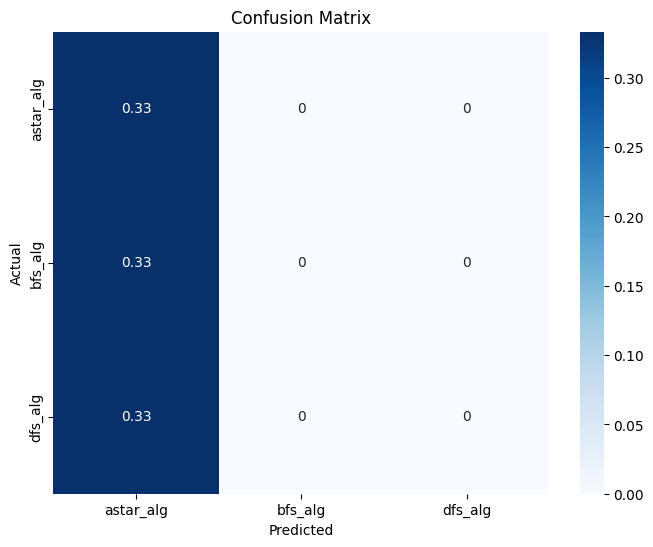

Overall Metrics:
Accuracy: 0.3333333333333333
Precision: 0.7777777777777778
Recall: 0.3333333333333333
F1-Score: 0.16666666666666666

Individual Class Metrics:
        class  accuracy  precision  recall  f1_score
0  astar_alg  0.333333   0.333333     1.0       0.5
1    bfs_alg  0.666667   1.000000     0.0       0.0
2    dfs_alg  0.666667   1.000000     0.0       0.0


In [26]:
from ipynb.fs.defs.learning import SimpleLinearNet

net = SimpleLinearNet(input_size = input_size, num_classes = num_classes).to(device)
name = "simple_net"

print(f"[i] Loading the network {net.__class__.__name__} ...")
#Loading existing models (with saved weights)
net.load_state_dict(torch.load(f'./runs/models/{(net.__class__.__name__).lower()}/{(net.__class__.__name__).lower()}_{name}_saved_model.pth',  map_location=device)) #using saved data if present
net.eval()

evaluate_model(net)

[i] Loading the network MoreComplexNet ...


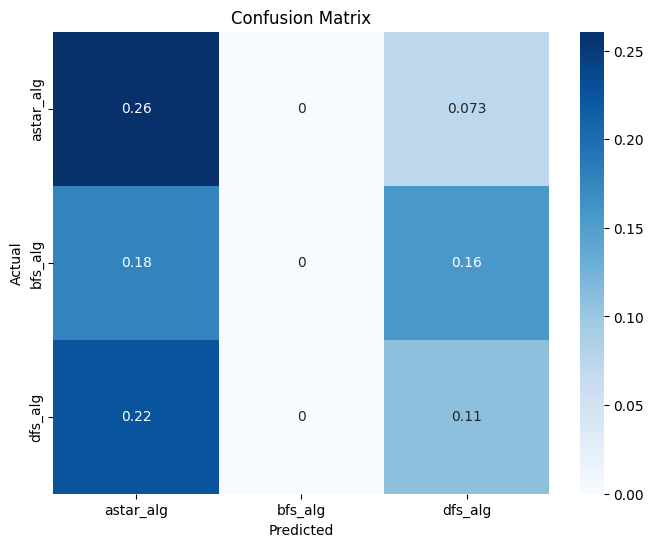

Overall Metrics:
Accuracy: 0.3696581196581197
Precision: 0.5721110657411187
Recall: 0.3696581196581197
F1-Score: 0.2828153048486008

Individual Class Metrics:
        class  accuracy  precision    recall  f1_score
0  astar_alg  0.525641   0.393548  0.782051  0.523605
1    bfs_alg  0.666667   1.000000  0.000000  0.000000
2    dfs_alg  0.547009   0.322785  0.326923  0.324841


In [27]:
from ipynb.fs.defs.learning import MoreComplexNet
net = MoreComplexNet(input_dim=input_size, num_classes=num_classes,
                     init_fn=torch.nn.init.xavier_normal_).to(device)
name = "more_complex_net"

print(f"[i] Loading the network {net.__class__.__name__} ...")
#Loading existing models (with saved weights)
net.load_state_dict(torch.load(f'./runs/models/{(net.__class__.__name__).lower()}/{(net.__class__.__name__).lower()}_{name}_saved_model.pth',  map_location=device)) #using saved data if present
net.eval()

evaluate_model(net)

[i] Loading the network EvenMoreComplexNet ...


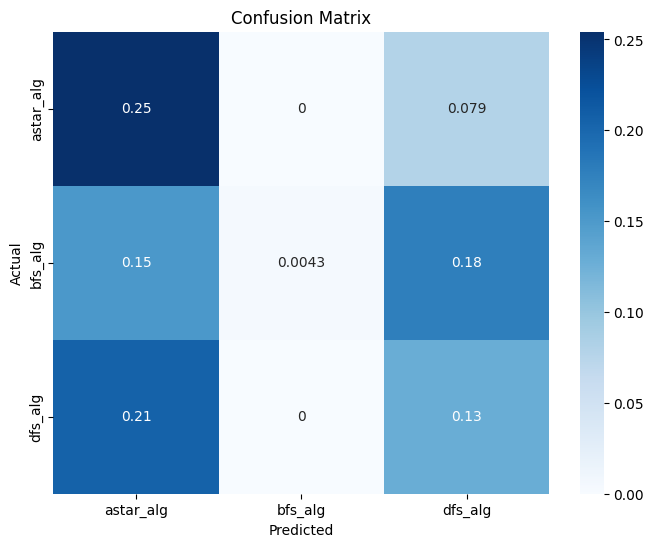

Overall Metrics:
Accuracy: 0.38675213675213677
Precision: 0.583139083139083
Recall: 0.38675213675213677
F1-Score: 0.3069736171001993

Individual Class Metrics:
        class  accuracy  precision    recall  f1_score
0  astar_alg  0.564103   0.416084  0.762821  0.538462
1    bfs_alg  0.670940   1.000000  0.012821  0.025316
2    dfs_alg  0.538462   0.333333  0.384615  0.357143


In [28]:
from ipynb.fs.defs.learning import EvenMoreComplexNet
net = EvenMoreComplexNet(input_dim=input_size, num_classes=num_classes,
                     init_fn=torch.nn.init.xavier_normal_).to(device)
name = "even_more_complex_net"

print(f"[i] Loading the network {net.__class__.__name__} ...")
#Loading existing models (with saved weights)
net.load_state_dict(torch.load(f'./runs/models/{(net.__class__.__name__).lower()}/{(net.__class__.__name__).lower()}_{name}_saved_model.pth',  map_location=device)) #using saved data if present
net.eval()

evaluate_model(net)

[i] Loading the network SimplestNet ...


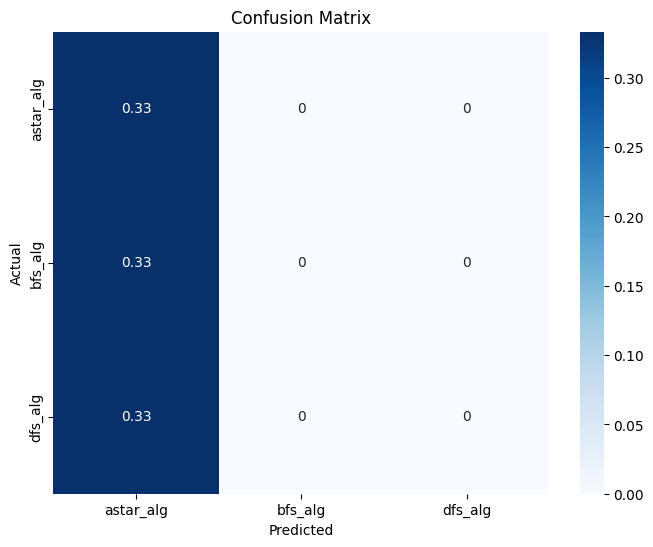

Overall Metrics:
Accuracy: 0.3333333333333333
Precision: 0.7777777777777778
Recall: 0.3333333333333333
F1-Score: 0.16666666666666666

Individual Class Metrics:
        class  accuracy  precision  recall  f1_score
0  astar_alg  0.333333   0.333333     1.0       0.5
1    bfs_alg  0.666667   1.000000     0.0       0.0
2    dfs_alg  0.666667   1.000000     0.0       0.0


In [29]:
from ipynb.fs.defs.learning import SimplestNet
net = SimplestNet(input_size=input_size, hidden_size=512, num_classes=num_classes, init_fn=torch.nn.init.xavier_normal_).to(device)
name = "simplest_net"

print(f"[i] Loading the network {net.__class__.__name__} ...")
#Loading existing models (with saved weights)
net.load_state_dict(torch.load(f'./runs/models/{(net.__class__.__name__).lower()}/{(net.__class__.__name__).lower()}_{name}_saved_model.pth',  map_location=device)) #using saved data if present
net.eval()

evaluate_model(net)